In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import scipy as sp
import h5py
from scipy.interpolate import interp1d
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import sys
import pseudo
import os
import glob
import miscUtil
import ops
%matplotlib inline

os.environ['DATA'] = os.environ['DATA186']
physDataDir = os.environ['DATA'] + 'phys/'
specDataDir = os.environ['DATA'] + 'spec/'
covDataDir = os.environ['DATA'] + 'cov/'
libDir = os.environ['LINLIB']


# Testing CC_AMA code

In [ ]:
os.chdir(libDir)
%run test_minimize.py
#os.chdir(specDataDir)

# Testing the Schur decomposition thingy
## $ Z = BH^* + HB^*$

In [3]:
# For random matrices:

# The decomposition should work for any Hermitian matrix,
Z = np.random.randn(21,21) + 1.j*np.random.randn(21,21)
Z = Z + Z.conj().T

B,H,S = ops.decomposeZ(Z)
print("Error in the decomposition for some random Hermitian matrix is,",
np.linalg.norm(
    Z - 
    (B @ H.conj().T + H @ B.conj().T),
    ord=2)/np.linalg.norm(Z,ord=2) )

Error in the decomposition for some random Hermitian matrix is, 3.81818613816e-15


In [4]:
a = 2.5; b = 20./3.; N = 62; Re = 186.
statInst = ops.statComp(a=a, b=b, N=N, Re=Re)
A, C, B = statInst.makeSystem()
Aadj, Cadj, Badj = statInst.makeAdjSystem()
X = B @ statInst.covMat @ B.conj().T
#X = (X + X.conj().T)/2.
Aadj = A.conj().T

Z = -(A @ X + X @ Aadj)
#Z = (Z + Z.conj().T)/2.
#Z = Z + 0.1*np.identity(Z.shape[0])
B,H,S = ops.decomposeZ(Z,threshold=1.0e-12)
print("Error in the decomposition for Z from covariance problem is,",
np.linalg.norm(
    Z - 
    (B @ H.conj().T + H @ B.conj().T),
    ord=2)/np.linalg.norm(Z,ord=2) )

Using parameters Re=186, alfa=46.5, kapa=0.61, N=62
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 6.666666666666667 186.0
a, b, Re: 2.5 6.666666666666667 186.0


/home/svadarevu/gitwork/linear/library/ops.py:190: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")


Error in the decomposition for Z from covariance problem is, 1.50444748409e-13


In [70]:
BHermErr = np.asmatrix(B).H - B.conj().T
np.linalg.norm(BHermErr, ord=2)

0.0

# Run phys2spec() for ReTau=186

In [ ]:
tArr = np.arange(100000,150050,50)
for t in tArr:
    miscUtil.phys2spec(t)

# Stat completition for turbulent channel flow

In [11]:
# Load turbulent mean for Re=590 from DNS data
#os.chdir(covDataDir)
#U0 = np.load(specDataDir+'uMeanN384.npy')
#U = np.zeros(U0.size+2)  # Add wall-nodes
#U[1:-1] = U0


# Interpolate to a grid with N=64 (internal nodes)
#N = 64
#Uc = pseudo.chebcoeffs(U)
#Uc = Uc[:N+2]
#U = pseudo.chebcoll_vec(Uc)
#U = U[1:-1] # Lose the wall-nodes



# Initialize statComp instance 
a = 2.5; b = 20./3.; N = 62; Re = 186.
statInst = ops.statComp(a=a, b=b, N=N, Re=Re)
# Re-assign attributes U, dU, d2U to reflect turbulent field
#statInst.U = U
#statInst.dU = statInst.D1 @ U
#statInst.d2U = statInst.D2 @ U




Using parameters Re=186, alfa=46.5, kapa=0.61, N=62
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.


In [ ]:
A,C,B = statInst.makeSystem()
X0= B @ statInst.covMat @ B.conj().T
Z0 = -(A @ X0 + X0 @ A.conj().T)
#outStats0 = outStats.copy()
outStats = statInst.completeStats(iterMax=np.int(2.2e06),tolPrimal=1.0e-03,tolDual=1.0e-03,rankPar=200.,
                                  savePath='../', savePrefix='test',
                                 X0=X0, Z0 = Z0)


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")


a, b, Re: 2.5 6.666666666666667 186.0
Parameters of the statComp instance are:
a:2.5, b:6.7, Re:186, N:62, rankPar:2e+02
a, b, Re: 2.5 6.666666666666667 186.0
a, b, Re: 2.5 6.666666666666667 186.0


/home/svadarevu/gitwork/linear/library/minimize.py:61: UserWarning: Be careful with array multiplication. All arrays are now matrices, so A*B is matrix multiplication, not elementwise multiplication.
  warn("Be careful with array multiplication. All arrays are now matrices, so A*B is matrix multiplication, not elementwise multiplication.")
/home/svadarevu/gitwork/linear/library/minimize.py:139: UserWarning: This code currently uses only method AMA. ADMM from the original matlab function hasn't been implemented.
  warn("This code currently uses only method AMA. ADMM from the original matlab function hasn't been implemented.")
/home/svadarevu/gitwork/linear/library/minimize.py:227: UserWarning: numpy's SVD factors as M=USV, not USV*
  warn("numpy's SVD factors as M=USV, not USV*")


No Y10 supplied, solving adjoing Lyapunov equation
Y10 from solve_lyapunov does not have attribute 'H', so it's an ndarray and not a matrix. I've recast it into matrix, but have a look at why this is happening....
Write decorators for timing and logging (have a look at your bookmarks on Chrome)

Starting iterations for AMA......
stepSize_BB  stepSize  tolPrimal   resPrimal  tolDual   abs(dualGap)    iter
1.5e-10   1.5e-10   0.001   5.686e+04   0.001  -1.2e+02       0  1
7.3e-10  7.25e-10   0.001   4.555e+04   0.001  -1.3e+02       0  2


/home/svadarevu/gitwork/linear/library/minimize.py:334: ComplexWarning: Casting complex values to real discards the imaginary part
  funPrimalArr[AMAstep] = -np.log( np.linalg.det( Xnew +0.j)) + rankPar * norm(Znew,ord='nuc')
/home/svadarevu/gitwork/linear/library/minimize.py:311: ComplexWarning: Casting complex values to real discards the imaginary part
  stepSize, tolPrimal, resPrimal, tolDual, (dualGap), np.sum(svalsNew), AMAstep) )


1.8e-09  1.82e-09   0.001   2.787e+04   0.001  -1.3e+02       0  3
5.6e-09  5.61e-09   0.001   1.915e+04   0.001  -1.3e+02       0  4
1.6e-08  1.65e-08   0.001   1.297e+04   0.001  -1.3e+02       0  5
2.1e-09  2.07e-09   0.001        8442   0.001  -1.2e+02       0  7
1.8e-07  1.85e-07   0.001        4515   0.001  -1.3e+02       0  9
3.1e-08  3.13e-08   0.001        3576   0.001  -1.2e+02       0  13
6.9e-09  6.93e-09   0.001        2929   0.001  -1.2e+02       0  18
9.1e-09  9.07e-09   0.001        2260   0.001  -1.2e+02       0  21
1.2e-08   1.2e-08   0.001        1882   0.001  -1.2e+02       0  40
2.1e-08  2.08e-08   0.001        1289   0.001  -1.2e+02       0  44
2.4e-08  2.42e-08   0.001        1129   0.001  -1.2e+02       0  76
2.5e-08  2.53e-08   0.001       982.2   0.001  -1.2e+02       0  82
6.2e-08  6.23e-08   0.001       879.5   0.001  -1.2e+02       0  92
6.8e-08  6.76e-08   0.001       775.6   0.001  -1.2e+02       0  118
4.8e-08   4.8e-08   0.001         666   0.001  -1.2e

/home/svadarevu/gitwork/linear/library/minimize.py:334: RuntimeWarning: divide by zero encountered in log
  funPrimalArr[AMAstep] = -np.log( np.linalg.det( Xnew +0.j)) + rankPar * norm(Znew,ord='nuc')


 0.0021   0.00207   0.001      0.6835   0.001  -1.2e+02  0.01694  8645
0.00041  0.000408   0.001      0.6146   0.001  -1.2e+02  0.01673  9483
  0.027    0.0274   0.001      0.5523   0.001  -1.2e+02  0.01671  10354
 0.0062   0.00623   0.001      0.4945   0.001  -1.2e+02  0.0171  11129
  0.031    0.0308   0.001      0.4448   0.001  -1.2e+02  0.01689  11719
 0.0024   0.00237   0.001      0.3988   0.001  -1.2e+02  0.0234  13106
 0.0016   0.00163   0.001      0.3447   0.001  -1.2e+02  0.02142  13116
 0.0028   0.00284   0.001      0.3045   0.001  -1.2e+02  0.01917  13389
 0.0033   0.00326   0.001      0.2696   0.001  -1.2e+02  0.02368  13949
  0.003   0.00305   0.001      0.2292   0.001  -1.2e+02  0.01722  14081
 0.0041   0.00406   0.001      0.2055   0.001  -1.2e+02  0.01708  15110
 0.0048   0.00484   0.001      0.1842   0.001  -1.2e+02  0.01756  15686
   0.16     0.158   0.001      0.1657   0.001  -1.2e+02  0.01719  17279
 0.0084   0.00838   0.001      0.1479   0.001  -1.2e+02  0.01702  18

In [26]:
with h5py.File('../testR186N62a10b10.hdf5',"r") as inFile:
    print([key for key in inFile.keys()])
    Xout = inFile['X'][:]
    dualGap = inFile['dualGapArr'][:]


['D', 'D1', 'D2', 'D4', 'U', 'X', 'Y1', 'Y2', 'Z', 'covMat', 'd2U', 'dU', 'dualGapArr', 'funDualArr', 'funPrimalArr', 'nu', 'outStats', 'structMat', 'w', 'y']


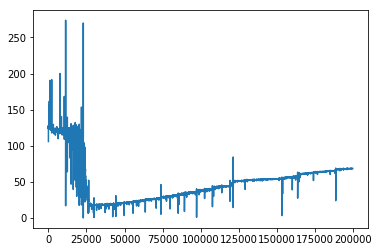

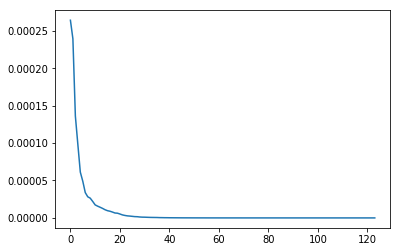

((-1547.947851942047-2.3867444367208144e-14j),
 array([-0.39428711 -3.90141761e-16j, -0.31275236 -7.90141638e-16j,
         0.29428413 -4.40382637e-16j,  0.23964524 -6.75127190e-17j,
         0.16146040 +1.57768926e-16j, -0.07602576 -6.33650027e-17j,
        -0.02219532 -3.12640832e-16j,  0.06587176 -2.28346039e-16j,
         0.00499222 -6.26206070e-16j,  0.08367035 +6.91716669e-16j]))

In [38]:
plt.plot(dualGap); plt.show()
X = B @ statInst.covMat @ B.conj().T
evals = np.linalg.eigvals(X)
evalsLog = np.linalg.eigvals(np.log(X))
plt.plot(np.real(evals)); plt.show()
np.sum(evalsLog), evalsLog[-10:]


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")


a, b, Re: 2.5 6.666666666666667 186.0


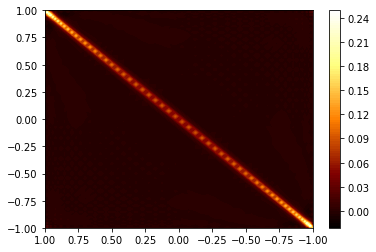

In [13]:
#X = outStats['X']
X = Xout.copy()
A,C,B = statInst.makeSystem()
Phi = C @ X  @ C.conj().T
N = statInst.N
qi = 1./np.sqrt(statInst.w)
WsqrtInv = np.diag(np.concatenate((qi,qi,qi)))
Phi_unweighted = WsqrtInv @ Phi @ WsqrtInv
covMat = Phi_unweighted[:N,:N]


covMat = 4.* covMat/(0.25*2./3.); y = statInst.y
#z = miscUtil.nodesCellCenters(nCells=192)
plt.contourf(y, y,np.real(covMat[0*N:1*N,0*N:1*N]),100,cmap=plt.get_cmap('afmhot'))
#plt.xscale("log")#; plt.yscale("log")
#plt.clim([0., 1.0e-4])
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.show()



/home/svadarevu/linenv/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


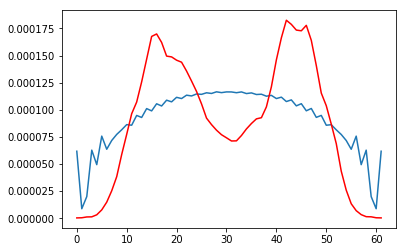

In [20]:
PhiDNS = statInst.covMat
XDNS = B @ PhiDNS @ B.conj().T
XCC = Xout

np.linalg.norm( np.diag(XDNS[:N,:N]) - np.diag(XCC[:N,:N])) 
plt.plot(np.diag(XCC[:N,:N]))
plt.plot(np.diag(XDNS[:N,:N]),'r')
plt.show()

In [ ]:
with h5py.File('../outStatsR186N62a00b06.hdf5','r') as inFile:
    pass

y = statInst.y
plt.contourf(y, y,np.abs(cov_uu[0*N:1*N,0*N:1*N]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.show()


# Matching eigenvalues of AX + XA*

In [99]:
a = 2.5; b = 20./3.; N = 62; Re = 186.
statInst = ops.statComp(a=a, b=b, N=N, Re=Re)

Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.


/home/svadarevu/gitwork/linear/library/ops.py:190: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  


a, b, Re: 2.5 6.666666666666666 186.0
a, b, Re: 2.5 6.666666666666666 186.0
X-X.H: 7.63957288533e-19
[-0.01134983 -0.00851934 -0.00366873 -0.00272076 -0.00205133] [ 0.00175568  0.00310145  0.00503213  0.01320469  0.01465298]


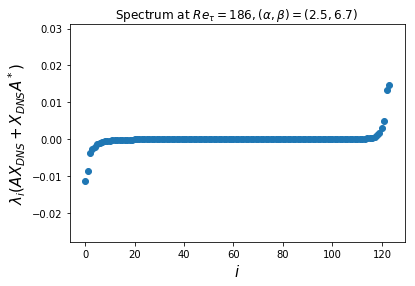

In [93]:
figureFolder='figures/'
A, C, B = statInst.makeSystem()
Aadj, Cadj, Badj = statInst.makeAdjSystem()
a0 = 0.25; b0 = 2./3.

Phi = statInst.covMat/a0/b0
Phi = 0.5*(Phi + Phi.conj().T)
X = B @ Phi @ B.conj().T
print("X-X.H:", np.linalg.norm((X - X.conj().T).flatten()))
Aadj = A.conj().T
X = (X + X.conj().T)/2.

evals,evecs = np.linalg.eig((A @ X + X @ Aadj ))
evals = evals.real
evals = np.sort(evals)
print(evals[:5], evals[-5:])
#evals = evals[4:-4]
plt.scatter(np.arange(evals.size),np.real(evals))
plt.xlabel("$i$",fontsize=15); plt.ylabel("$\lambda_i(AX_{DNS} + X_{DNS}A^*)$",fontsize=15)
plt.title("Spectrum at $Re_{\\tau}=186, (\\alpha,\\beta) = (2.5,6.7)$ ")
#plt.ylim([-0.015,0.005])
plt.savefig(figureFolder+'spectrum.pdf',format='pdf')
plt.show()

array([ 0.11285152,  0.19399631,  0.24795435,  0.02357624,  0.10440523,
        0.26959656,  0.41470865,  0.69431979,  0.72204984,  0.81876371,
        0.80276107,  0.86441545,  0.87030961,  0.87907155,  0.92228337,
        0.9401819 ,  0.92914385,  0.93122482,  0.9515191 ,  0.94439813,
        0.95843334,  0.95610136,  0.95594594,  0.96355392,  0.97487274,
        0.97355528,  0.97604876,  0.97564922,  0.98031156,  0.98587451,
        0.99039507,  0.98974669,  0.99113285,  0.99182691,  0.99299565,
        0.99303558,  0.99165317,  0.99540189,  0.99670833,  0.99839876,
        0.9982451 ,  0.99913102,  1.00000814,  1.00018693,  1.00137889,
        1.00228023,  1.00818568,  1.01256848,  1.02028955,  1.02825255,
        1.03995437,  1.05287214,  1.05952668,  1.10011885,  1.14042547,
        1.19053371,  1.25036709,  1.34716218,  1.39336876,  1.54410316,
        1.68639699,  1.95687447])

In [44]:
dynMat, outMat, outMatInv = statInst.makeSystem()
a0 = 0.25; b0 = 2./3.
cov_vel = 4.*statInst.covMat

# Make covariances symmetric about centerline
for ind0 in range(3):
    for ind1 in range(3):
        tmpArr = cov_vel[ind0*N:ind0*N+N, ind1*N:ind1*N+N]  
        #cov_vel[ind0*N:ind0*N+N, ind1*N:ind1*N+N] = 0.5 * (tmpArr + tmpArr[::-1,::-1])
cov_vel_tmp = cov_vel.copy()        


# Compute covariance of state, X, from covariance of velocity, Phi
# Phi = W1/2 v  (W1/2 v)* = C psi  (C psi)* = C X C*
cov_state = outMatInv @ cov_vel @ outMatInv.conj().T

if False:
    C_phi = statInst.velVor2primitivesMat(a=statInst.a, b=statInst.b)
    W = np.diag( np.concatenate(( statInst.w, statInst.w, statInst.w )) )
    Q = C_phi.conj().T @ W @ C_phi
    Qsqrt = sqrtm(Q)
    B = statInst.primitives2velVorMat(a=statInst.a, b=statInst.b)

    # Need this matrix to convert covariance of weighted velocities to 
    #    covariance of unweighted velocities
    WsqrtInv = np.diag( np.sqrt(2.* (1./np.concatenate(( statInst.w, statInst.w, statInst.w ))) ) )
    # The factor 2 shows up because I changed the definition of 'w' since I computed 
    #    the covariances of weighted velocities
    cov_vel = WsqrtInv @ cov_vel @ WsqrtInv

    if False:
        cov_vel = statInst.structMat * cov_vel

    cov_state = Qsqrt @ B @ cov_vel @ B.conj().T  @ Qsqrt.conj().T


a, b, Re: 2.5 6.666666666666667 186.0


In [45]:
cov_vel_new = outMat @ cov_state @ outMat.conj().T
np.linalg.norm( (cov_vel_new - cov_vel).flatten())


4.7917421691850325e-05

[-0.00706376 -0.00543383 -0.00190116 -0.00146003 -0.00102909] [ 0.00095781  0.0014689   0.0027523   0.00860049  0.00946789]


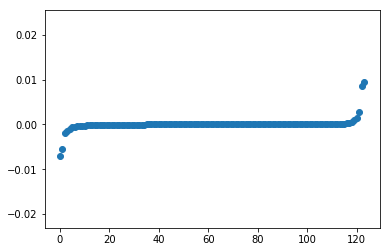

In [46]:
A = dynMat; X = cov_state
evals,evecs = np.linalg.eig(A @ X + X @ A.conj().T )
evals = evals.real
evals = np.sort(evals)
print(evals[:5], evals[-5:])
#evals = evals[4:-4]
plt.scatter(np.arange(evals.size),np.real(evals))
#plt.ylim([-0.015,0.005])
#plt.savefig(figureFolder+'spectrum.pdf',format='pdf')
plt.show()

In [125]:
from scipy.linalg import solve_lyapunov
Z0 = -(A @ X + X @ A.conj().T)
B,H,S = ops.decomposeZ(Z0)
np.linalg.matrix_rank(B), B.shape[0]

(79, 124)

In [126]:
H.shape

(124, 79)

In [127]:
C = outMat
Cf = ( H.conj().T - 0.5 * B.conj().T) @ np.linalg.inv(X)
Af = A + B @ Cf
omegaArr = np.arange(0., 101., 5.)
psdArr = np.zeros(omegaArr.size)
ampArr = psdArr.copy()
I = np.identity(Af.shape[0])

for ind in range(omegaArr.size):
    omega = omegaArr[ind]
    T_vw = -C @ np.linalg.pinv(1.j*omega*I + Af) @ B
    svalMax = np.linalg.norm(T_vw, ord=2)
    traceTT = np.trace( T_vw @ T_vw.conj().T )
    psdArr[ind] = traceTT
    ampArr[ind] = svalMax**2

/home/svadarevu/linenv/lib/python3.5/site-packages/ipykernel/__main__.py:14: ComplexWarning: Casting complex values to real discards the imaginary part


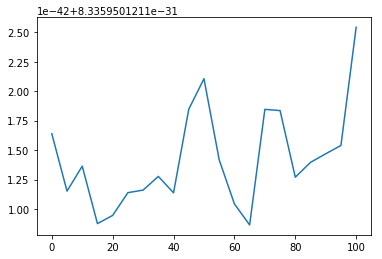

In [128]:
plt.plot(omegaArr, np.abs(psdArr))
plt.show()

In [129]:
omega=40.
T_vw = -C @ np.linalg.pinv(1.j*omega*I + Af) @ B
U,S,V = np.linalg.svd(T_vw)
noise = np.random.randn(T_vw.shape[1])
velVec = T_vw @ noise

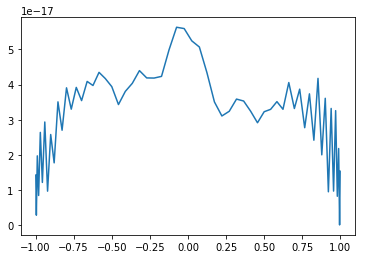

In [130]:
N = statInst.N
plt.plot(statInst.y, np.abs(velVec[N:2*N]))
plt.show()

# Verifying covariance ordering

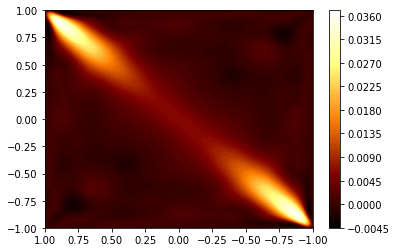

In [17]:
N = 62; a0 = 0.25; b0 = 2./3.
#covMat = statInst.covMat
covMat = cov_vel_tmp
q = np.sqrt(pseudo.clencurt(N))
Qinv = np.diag( 1./np.concatenate((q,q,q)))
covMat = Qinv @ covMat @ Qinv
covMat = 4.* covMat/a0/b0
#z = miscUtil.nodesCellCenters(nCells=192)
z = pseudo.chebdif(N,1)[0]
plt.contourf(z, z,np.real(covMat[0*N:1*N,0*N:1*N]),100,cmap=plt.get_cmap('afmhot'))
#plt.xscale("log")#; plt.yscale("log")
#plt.clim([0., 1.0e-4])
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.show()
#print(np.diag(covMat[:N,:N]))

In [ ]:
uff0 = miscUtil.bin2arr(specDataDir+'uFF_it45000.dat')
uffRealSum = uff0.copy().real
uffAbsSum = np.abs(uff0.copy())
for t in range(45500,75500,500):
    uff = miscUtil.bin2arr(specDataDir+'uFF_it%d.dat'%t)
    uffRealSum += uff.real
    uffAbsSum += np.abs(uff)
uffRealSum = uffRealSum/301.
uffAbsSum  = uffAbsSum/301.
z = pseudo.chebdif(386,1)[0][1:-1]
#plt.plot(z, uffRealSum, z, uffAbsSum)
#plt.show()

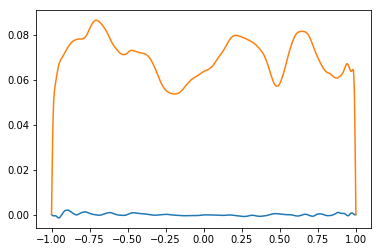

In [32]:
plt.plot(z, uffRealSum[2,0], z, uffAbsSum[2,0])
plt.show()

# Covariance matrices from DNS

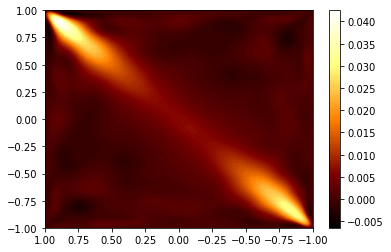

In [23]:
N = 62; a0 = 0.25; b0 = 2./3.
covDataDir = os.environ['DATA186']+'cov/'
covMat =np.load(covDataDir+'covR186N192l10m10.npy')
q = np.sqrt(2.*pseudo.clencurt(N))
Qinv = np.diag( 1./np.concatenate((q,q,q)))
covMat = Qinv @ covMat @ Qinv
covMat = 4.* covMat/a0/b0
#z = miscUtil.nodesCellCenters(nCells=192)
z = pseudo.chebdif(N,1)[0]
plt.contourf(z, z,np.real(covMat[0*N:1*N,0*N:1*N]),100,cmap=plt.get_cmap('afmhot'))
#plt.xscale("log")#; plt.yscale("log")
#plt.clim([0., 1.0e-4])
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.show()
#print(np.diag(covMat[:N,:N]))

# Premultiplied energy spectrum

In [ ]:
a = 0.25; b=2./3.
lArr = np.arange(1., 32.)
mArr = np.arange(24.)
N = 192
energyArr = np.zeros((lArr.size+1, N))
premulEnergyArr = energyArr.copy()
for l in lArr:
    kx = l*a
    for m in mArr:
        covMat = np.load(covDataDir + 'covR186N192l%02dm%02d.npy'%(l,m))
        energyArr[int(l)] += np.diag(np.abs(covMat[:N,:N]))
    
    premulEnergyArr[int(l)] = kx*energyArr[int(l)]
    

    
    
#z = pseudo.chebdif(N+2,0)[0][1:-1]
plt.contourf(lArr[1:], z, premulEnergyArr.T)
plt.colorbar()
plt.show()
    
    
    

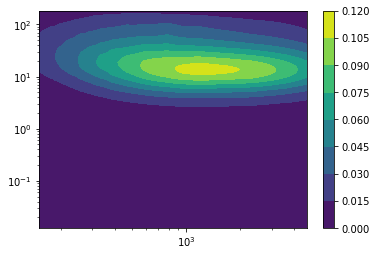

In [29]:
z = miscUtil.nodesCellCenters(nCells=192)
plt.contourf(186.*2.*np.pi/a/lArr, 186.*(1.-z[:96]), premulEnergyArr[1:,:96].T)
plt.yscale('log')
plt.xscale('log')
plt.colorbar()
plt.show()


In [23]:
lArr.shape, z.shape, premulEnergyArr.T.shape

((31,), (192,), (192, 32))

In [ ]:
print(premulEnergyArr[1:].T.shape,lArr[1:].shape, z.shape)
phi11 = premulEnergyArr[1:, :-33:-1]
plt.contourf(590.*2.*np.pi/lArr, 590.*(1.-z[:32]), phi11.T)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('$\lambda_x^+$',fontsize=15); plt.ylabel('$z^+$',fontsize=15)
plt.title('$\phi_{11}$ at bottom wall',fontsize=15)
plt.colorbar()
plt.show()

(64, 64) (63,) (384,)


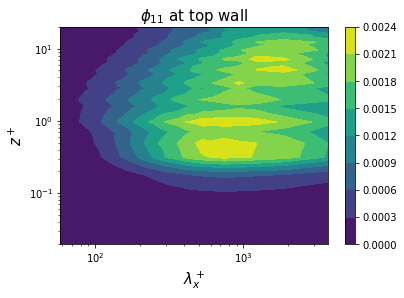

In [54]:
print(premulEnergyArr[1:].T.shape,lArr[1:].shape, z.shape)
phi11 = premulEnergyArr[1:, :32]
plt.contourf(590.*2.*np.pi/lArr, 590.*(1.-z[:32]), phi11.T)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('$\lambda_x^+$',fontsize=15); plt.ylabel('$z^+$',fontsize=15)
plt.title('$\phi_{11}$ at top wall',fontsize=15)
plt.colorbar()
plt.show()

In [4]:
a = 0.04
svals = 0.001 * np.arange(1.,50.)

In [23]:
svals = np.abs(svals)
svalsNew = svals.copy()
svalsNew[svals<=a] = 0.
svalsNew[svals>a] = svals[svals>a] - a


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

In [5]:
svalsNew = (  ( 1. - a/np.abs(svals) ) * svals)  * (np.abs(svals) > a).astype(int)
svalsNew = np.abs(svalsNew)


In [8]:
svalsNew

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.001,  0.002,  0.003,  0.004,  0.005,  0.006,  0.007,  0.008,
        0.009])

Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
a, b, Re: 0.5 1.0 2000.0
Eigenvalue solution returned with error norm: 3.70352287928e-11
(162,) (162, 162) (81,)


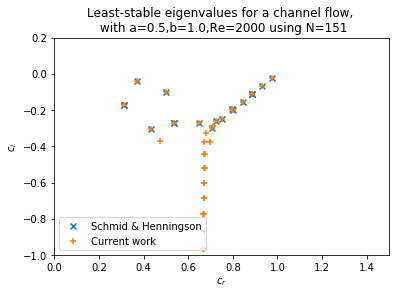

In [18]:
%run validate_LSA_channel.py

# Component-wise energy amplification
Jovanovic & Bamieh (2005) JFM

In [89]:
from scipy.linalg import solve_sylvester
N=100
aArr = 10**np.linspace(-4., 0.5, 50)
bArr = 10**np.linspace(-2., 1.2, 90)
H2normArr = np.zeros((aArr.size, bArr.size))
H2normArrTest = np.zeros((aArr.size, bArr.size))

for ind0 in range(aArr.size):
    a = aArr[ind0]
    for ind1 in range(bArr.size):
        b = bArr[ind1]
        k2 = a**2 + b**2
        I = np.identity(N); Z = np.zeros((N,N), dtype=np.complex)
        covMat = np.identity(3*N)
        statInst = ops.statComp(Re=2000., a=a, b=b, N=N, covMat = covMat)
        statInst.U = 1. - statInst.y**2
        statInst.dU = -2.*statInst.y
        statInst.d2U = -2.*np.ones(N)
        Umat = np.diag(statInst.U)
        dUmat = np.diag(statInst.dU)
        d2Umat = np.diag(statInst.d2U)
        Re = statInst.Re
        
        A, C, B = statInst.makeSystem()
        Badj = C.copy()
        Cadj = B.copy()
        
        # Building Aadj:
        Aadj = np.zeros((2*N, 2*N), dtype=np.complex)
        Delta = statInst.D2 - k2 * I
        DeltaInv = np.linalg.solve(Delta, I)
        Aadj11 = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + \
                1./Re*DeltaInv @ (Delta @ Delta)
        Aadj22 = 1.j*a*Umat + 1./Re*Delta
        Aadj21 = -1.j*b*DeltaInv @ dUmat
        
        Aadj = np.vstack(( 
                np.hstack(( Aadj11, Aadj21 )),
                np.hstack((  Z    , Aadj22 ))   ))
        
        # Solve Sylvester equation, AX + XB = Q, arguments to the function are A,B,Q
        # In present formulation, the equation is AX + X A* = - B B*
        X = solve_sylvester(A, Aadj, - B @ Badj)
                
        
        H2normArr[ind0,ind1] = np.sqrt(np.trace( X @ Cadj @ C))
        #H2normArrTest[ind0,ind1] = np.trace( )
        

Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0001 0.01 2000.0


/home/svadarevu/linenv/lib/python3.5/site-packages/ipykernel/__main__.py:45: ComplexWarning: Casting complex values to real discards the imaginary part


Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0001 0.0108631319854 2000.0
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0001 0.0118007636532 2000.0
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Usi

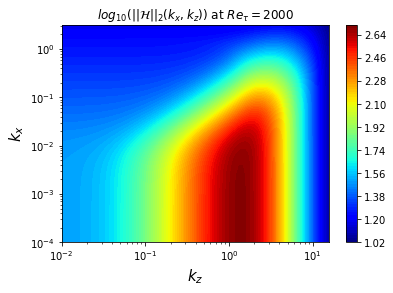

In [138]:
plt.contourf(bArr, aArr, np.log10(H2normArr),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.colorbar()
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}||_2 (k_x,k_z))$ at $Re_\\tau = 2000$")
plt.savefig('figures/'+'gainLaminar.pdf',format='pdf')
plt.show()

In [132]:
from scipy.linalg import solve_sylvester
a = 1.; b= 1.; N = 50; k2 = a**2 + b**2
I = np.identity(N); Z = np.zeros((N,N), dtype=np.complex)

covMat = np.identity(3*N)
statInst = ops.statComp(Re=2000., a=a, b=b, N=N, covMat=covMat)
statInst.U = 1. - statInst.y**2
statInst.dU = -2.*statInst.y
statInst.d2U = -2.*np.ones(N)
Umat = np.diag(statInst.U)
dUmat = np.diag(statInst.dU)
d2Umat = np.diag(statInst.d2U)
Re = statInst.Re


A, C, B = statInst.makeSystem()
Badj = C.copy()
Cadj = B.copy()

# Building Aadj:
Aadj = np.zeros((2*N, 2*N), dtype=np.complex)
Delta = statInst.D2 - k2 * I
DeltaInv = np.linalg.solve(Delta, I)
Aadj11 = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + \
        1./Re*DeltaInv @ (Delta @ Delta)
Aadj22 = 1.j*a*Umat + 1./Re*Delta
Aadj21 = -1.j*b*DeltaInv @ dUmat

Aadj = np.vstack(( 
        np.hstack(( Aadj11, Aadj21 )),
        np.hstack((  Z    , Aadj22 ))   ))

X1 = solve_sylvester(A, Aadj, - B @ Badj)
X2 = solve_sylvester(A, A.conj().T, - B @ B.conj().T)

Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1.0 1.0 2000.0


In [134]:
np.linalg.norm((np.diag(X1)-np.diag(X2)).flatten())

534.17962647146351

AttributeError: module 'numpy' has no attribute 'ismatrix'

# Rank(Z) at $Re_\tau = 186$

In [ ]:
lArr = np.arange(-48,49); mArr = np.arange(33)
BrankArr = np.zeros((lArr.size,mArr.size),dtype=np.int)
a0 = 0.25; b0 = 2./3.
N = 62; Re = 186.


for ind0 in range(lArr.size):
    l = lArr[ind0]
    for ind1 in range(mArr.size):
        m = mArr[ind1]
        if not ( (l==0) and (m==0) ):
            a = l * a0 ; b = m * b0
            statInst = ops.statComp(a=a, b=b, N=N, Re=Re)

            A, C, B = statInst.makeSystem()
            Aadj, Cadj, Badj = statInst.makeAdjSystem()

            Phi = statInst.covMat/a0/b0
            Phi = 0.5*(Phi + Phi.conj().T)
            X = B @ Phi @ Badj

            Z =   -(A @ X + X @ Aadj)
            B,H,S = ops.decomposeZ(Z)

            BrankArr[ind0,ind1] = np.linalg.matrix_rank(B)
            print('Rank(B):',BrankArr[ind0,ind1]);print();print()
        

        
        


Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l-48m00.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: -12.0 0.0 186.0
a, b, Re: -12.0 0.0 186.0
Rank(B): 73


Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov

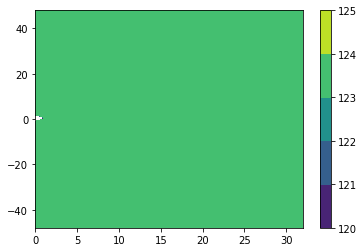

In [14]:
BrankArr[49,0] = 100

plt.contourf(mArr, lArr, BrankArr,levels=np.arange(120,126))

plt.colorbar()
plt.show()


In [13]:
BrankArr[59,10]

124

In [8]:
a0 = 0.25; b0 = 2./3.
a = 10.*a0 ; b = 10.* b0; N = 62; Re=186.
statInst = ops.statComp(a=a, b=b, N=N, Re=Re)

A, C, B = statInst.makeSystem()
Aadj, Cadj, Badj = statInst.makeAdjSystem()

Phi = statInst.covMat/a0/b0
Phi = 0.5*(Phi + Phi.conj().T)
X = B @ Phi @ Badj

Z =   -(A @ X + X @ Aadj)
B,H,S = ops.decomposeZ(Z)

U,S,V = np.linalg.svd(B)

S[65:85], np.linalg.matrix_rank(B)


Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 6.666666666666666 186.0
a, b, Re: 2.5 6.666666666666666 186.0


(array([ 0.00085905,  0.00076613,  0.00067989,  0.00059549,  0.00051746,
         0.00047715,  0.00039269,  0.00036234,  0.00035867,  0.00027794,
         0.00025829,  0.00020098,  0.00014216,  0.00010965,  0.00010717]), 80)

In [12]:
H.shape

(124, 80)

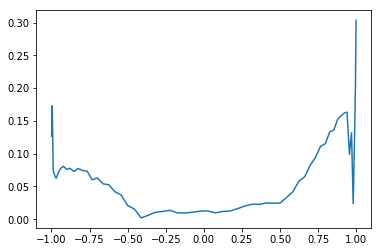

In [15]:
stateBase = B[:,0]
primBase = C @ stateBase
primUnweightedBase = statInst._deweightVec(primBase)


plt.plot(statInst.y, np.abs(primUnweightedBase[:N]))
plt.show()

Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.


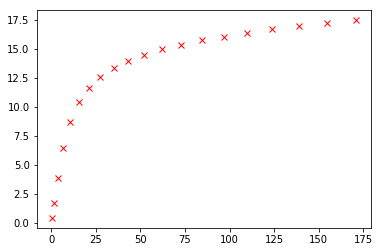

In [21]:
statInst = ops.statComp(a=2.5,b=7.,N=150,Re=2003.,covMat=np.identity(450))
plt.plot(2003.*(1.-statInst.y[:20]), statInst.U[:20],'rx'); plt.show()

In [26]:
(1.-statInst.y[25:32]),statInst.U[25:32]

(array([ 0.14277317,  0.15367136,  0.16493587,  0.17656183,  0.18854421,
         0.20087783,  0.21355734]),
 array([ 18.79869843,  18.99210602,  19.17970586,  19.36192405,
         19.53914007,  19.71169249,  19.87988369]))

# Linear model from full covariance matrices

Using parameters Re=186, alfa=46.5, kapa=0.61, N=62
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 6.666666666666666 186.0


/home/svadarevu/gitwork/linear/library/ops.py:190: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  


Rel. error in decomposition is  1.41688223423e-13


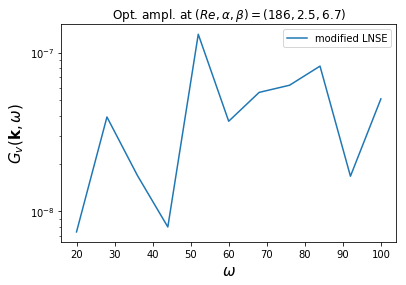

In [91]:
a0 = 0.25; b0 = 2./3.; l = 10; m = 10; N = 62; Re = 186.
a = l*a0; b = m*b0
omegaArr = np.linspace(20., 100.,11)
ampArr = np.zeros(omegaArr.size)

statInst = ops.statComp(a=a, b=b, N=N, Re=Re)
A, C, B = statInst.makeSystem()
#Aadj, Cadj, Badj = statInst.makeAdjSystem()
Aadj = A.conj().T; Cadj = C.conj().T; Badj = B.conj().T

Phi = statInst.covMat
X = B @ Phi @ Badj
#X = 0.5*( X + X.conj().T )

Z = -(A @ X + X @ Aadj)
B, H, S = ops.decomposeZ(Z)
errDec = (B @ H.conj().T + H @ B.conj().T) - Z
print("Rel. error in decomposition is ", np.linalg.norm(errDec,ord=2)/np.linalg.norm(Z,ord=2))

Cf = (H.conj().T - 0.5 * B.conj().T) @ np.linalg.solve(X, np.identity(X.shape[0]))
Af = A + B @ Cf

for ind in range(omegaArr.size):
    omega = omegaArr[ind]
    R = (1.j*omega*np.identity(Af.shape[0]) + Af )
    R = np.linalg.solve(R, np.identity(Af.shape[0]))
    Tvw = -C @ R @ B
    
    U,S,V = np.linalg.svd(Tvw)
    
    ampArr[ind] = np.real(S[0])**2
    
figureFolder="figures/"
plt.plot(omegaArr, ampArr)
#plt.ylim([1.0e-06, 100.])
plt.yticks(10**np.array([-6.,-4.,-2.,0,2]))
plt.yscale("log")
plt.xlabel("$\\omega$", fontsize=15); plt.ylabel("$G_v(\mathbf{k},\\omega)$",fontsize=15)
plt.legend(['modified LNSE'])
plt.title("Opt. ampl. at $(Re,\\alpha,\\beta) =(186,2.5,6.7)$")
#plt.savefig(figureFolder+"optAmpMod.pdf",format="pdf")
plt.show()


In [59]:
B.shape, H.shape, A.shape, X.shape

((124, 80), (124, 80), (124, 124), (124, 124))

# Frequency response, from resolvent

In [40]:
a0 = 0.25; b0 = 2./3.; l = 10; m = 10; N = 62; Re = 186.
a = l*a0; b = m*b0
omegaArr = np.linspace(-100., 100.,201)
ampArrLNSE = np.zeros(omegaArr.size)
ampArrEddy =  np.zeros(omegaArr.size)
psdArrLNSE = np.zeros(omegaArr.size)
psdArrEddy = np.zeros(omegaArr.size)

statInst = ops.statComp(a=a, b=b, N=N, Re=Re)
A, C, B = statInst.makeSystem()
Ae, Ce, Be = statInst.makeSystem(nu=statInst.nu)
N = A.shape[0]; I = np.identity(N,dtype=np.complex)

for ind in range(omegaArr.size):
    omega = omegaArr[ind]
    R = (1.j*omega*I + A )
    R = np.linalg.solve(R, I)
    Tvw = -C @ R @ B
    U,S,V = np.linalg.svd(Tvw)
    
    Re = (1.j*omega*I + Ae )
    Re = np.linalg.solve(Re, I)
    Tvw_e = -C @ Re @ B
    U,Se,V = np.linalg.svd(Tvw_e)
    
    ampArrLNSE[ind] = np.real(S[0])**2
    ampArrEddy[ind] = np.real(Se[0])**2
    
    psdArrLNSE[ind] = np.sum( np.real(S )**2 )
    psdArrEddy[ind] = np.sum( np.real(Se)**2 )
    



Using parameters Re=186, alfa=46.5, kapa=0.61, N=62
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 6.666666666666666 186.0


/home/svadarevu/gitwork/linear/library/ops.py:190: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  


a, b, Re: 2.5 6.666666666666666 186.0


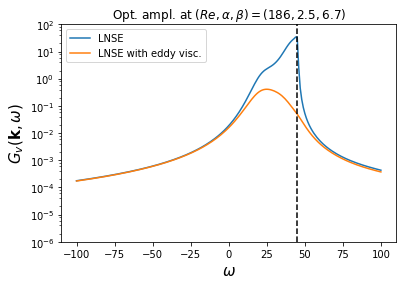

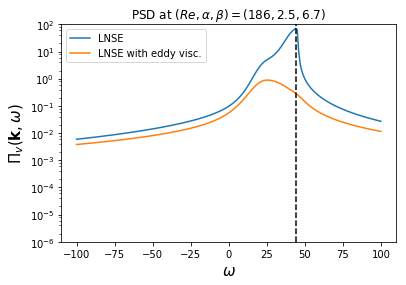

In [55]:
figureFolder="figures/"
plt.plot(omegaArr, ampArrLNSE)
plt.plot(omegaArr, ampArrEddy)
omegaInd = np.argmax(ampArrLNSE); omegaMax = omegaArr[omegaInd]
plt.plot(omegaMax*np.ones(15), 10**np.linspace(-6,2,15), 'k--')
plt.ylim([1.0e-06, 100.])
plt.yticks(10**np.array([-6.,-4.,-2.,0,2]))
plt.yscale("log")
plt.xlabel("$\\omega$", fontsize=15); plt.ylabel("$G_v(\mathbf{k},\\omega)$",fontsize=15)
plt.legend(['LNSE', 'LNSE with eddy visc.'])
plt.title("Opt. ampl. at $(Re,\\alpha,\\beta) =(186,2.5,6.7)$")
plt.savefig(figureFolder+"optAmpLNSE.pdf",format="pdf")
plt.show()

plt.plot(omegaArr, psdArrLNSE)
plt.plot(omegaArr, psdArrEddy)
omegaInd = np.argmax(psdArrLNSE); omegaMax = omegaArr[omegaInd]
plt.plot(omegaMax*np.ones(15), 10**np.linspace(-6,2,15), 'k--')
plt.ylim([1.0e-06, 100.])
plt.yticks(10**np.array([-6.,-4.,-2.,0.,2.]))
plt.yscale("log")
plt.xlabel("$\\omega$", fontsize=15); plt.ylabel("$\\Pi_v(\mathbf{k},\\omega)$",fontsize=15)
plt.legend(['LNSE', 'LNSE with eddy visc.'])
plt.title("PSD at $(Re,\\alpha,\\beta) =(186,2.5,6.7)$")
plt.savefig(figureFolder+"psdLNSE.pdf",format="pdf")
plt.show()

In [49]:
omegaInd = np.argmax(ampArrLNSE)
omegaArr[omegaInd]

45.0

In [24]:
uu = 4.*statInst.covMat[2*N:3*N,2*N:3*N]/(0.25*2./3.)
qi = 1./np.sqrt(statInst.w)
Qinv = np.diag( qi)
uu = Qinv @ uu @ Qinv
uu_coeffs = pseudo.chebcoeffs(np.diag(uu))
np.abs(uu_coeffs) < 0.001*np.abs(uu_coeffs[0]), np.abs(uu_coeffs)

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False,
        False,  True, False,  True,  True, False, False, False, False,
         True,  True, False, False,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True], dtype=bool),
 array([  5.46081274e-03,   5.55473295e-04,   1.39706428e-03,
          1.83760660e-04,   3.60577104e-03,   3.08167818e-04,
          2.11810993e-03,   4.03277017e-04,   8.36958720e-04,
          8.79973591e-05,   5.54349366e-04,   1.25162857e-04,
          1.40759602e-04,   1.77186974e-04,   2.40765034e-05,
          2.06746742e-05,   4.18042652e-05,   3.85245072e-05,
          7.93202820e-05,   7.88891704e-05,   2.00100725e-04,
          2.70147833e-05,   9.08227447e-05,   7.07948861e-05,
